<a href="https://colab.research.google.com/github/deep12030/Advance-Machine-learning-DL-/blob/main/Transformer_Based_Recommendations_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [47]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy import stats
from scipy.spatial.distance import pdist
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from itertools import cycle
import string
from collections import Counter
from keras.layers.embeddings import Embedding
from keras.layers import Input, merge
from keras.models import Model
from keras.layers.core import Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.layers.recurrent import GRU, LSTM
from keras import backend as K

# Data Preparation

In [6]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

loading the data into pandas DataFrames with their proper column names.

In [7]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

movies = pd.read_csv(
    "ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='pyth

# Data Exploration

Check for null values

In [8]:
users.isnull().sum()

user_id       0
sex           0
age_group     0
occupation    0
zip_code      0
dtype: int64

user Info

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   sex         6040 non-null   object
 2   age_group   6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip_code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


 User Age Distribution

In [10]:
users.groupby('age_group')['user_id'].count()

age_group
1      222
18    1103
25    2096
35    1193
45     550
50     496
56     380
Name: user_id, dtype: int64

<function matplotlib.pyplot.show>

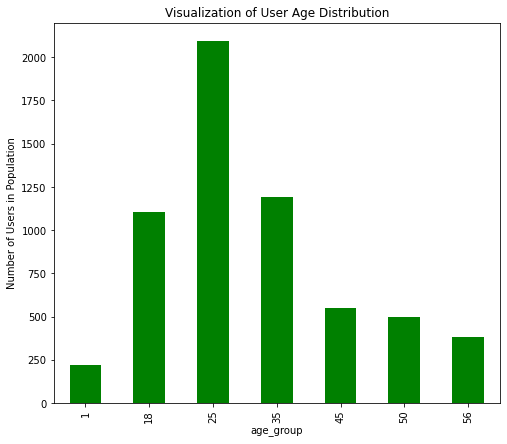

In [11]:
users.groupby('age_group')['user_id'].count().plot(kind = 'bar', color = 'green',figsize = (8,7))
plt.xlabel('age_group')
plt.ylabel('Number of Users in Population')
plt.title('Visualization of User Age Distribution')
plt.show

Checking for rating null values

In [12]:
ratings.isnull().sum()

user_id           0
movie_id          0
rating            0
unix_timestamp    0
dtype: int64

In [13]:
ratings.describe()

,user_id,movie_id,rating,unix_timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [14]:
ratings.head(5)

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [15]:
movies.isnull().sum()

movie_id    0
title       0
genres      0
dtype: int64

In [16]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


movies rating vs Frequency

Shape of the joint data frame: (1000209, 6)
   user_id  movie_id  ...                                   title  genres
0        1      1193  ...  One Flew Over the Cuckoo's Nest (1975)   Drama
1        2      1193  ...  One Flew Over the Cuckoo's Nest (1975)   Drama
2       12      1193  ...  One Flew Over the Cuckoo's Nest (1975)   Drama
3       15      1193  ...  One Flew Over the Cuckoo's Nest (1975)   Drama
4       17      1193  ...  One Flew Over the Cuckoo's Nest (1975)   Drama

[5 rows x 6 columns]
user_id 6040
movie_id 3706
rating 5
unix_timestamp 458455
title 3706
genres 301


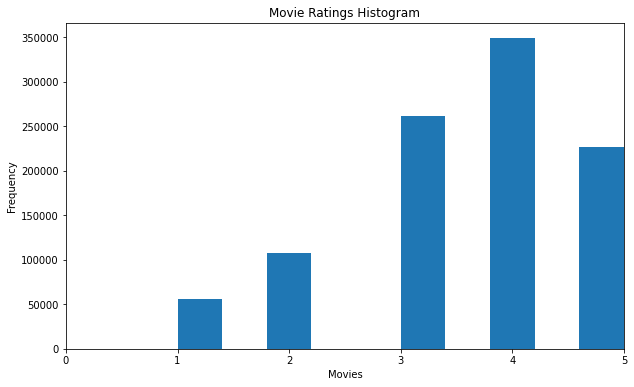

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.merge(ratings, movies, how='inner')
print ('Shape of the joint data frame:', data.shape)
print (data.head(n=5))
for column in data.columns:
    print (column, data[column].nunique())
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(data['rating'],10)
plt.xlabel('Movies'); 
plt.ylabel('Frequency')
plt.xlim(0,5)
plt.title('Movie Ratings Histogram')
plt.show()

Top 25 movies by viewership rating

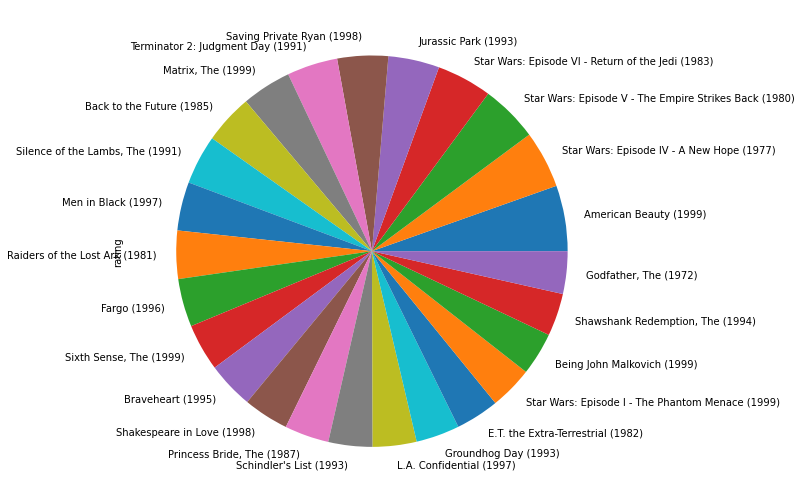

In [18]:
data.groupby('title')['rating'].count().sort_values(ascending = False)[:25].plot(kind = 'pie', figsize = (10,9))

Least 25 movies by viewership rating

In [19]:
data.groupby('title')['rating'].count().sort_values(ascending = True)[:25]

title
Another Man's Poison (1952)                                              1
Night Tide (1961)                                                        1
Shadows (Cienie) (1988)                                                  1
McCullochs, The (1975)                                                   1
Anna (1996)                                                              1
Target (1995)                                                            1
Even Dwarfs Started Small (Auch Zwerge haben klein angefangen) (1971)    1
Tashunga (1995)                                                          1
Waltzes from Vienna (1933)                                               1
Open Season (1996)                                                       1
I Don't Want to Talk About It (De eso no se habla) (1993)                1
Jar, The (Khomreh) (1992)                                                1
Waiting Game, The (2000)                                                 1
Voyage to the Begin

In [20]:
rating1 = ratings.copy()
rating1

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [21]:
new = movies[['movie_id', 'title']].copy()
new

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
3878,3948,Meet the Parents (2000)
3879,3949,Requiem for a Dream (2000)
3880,3950,Tigerland (2000)
3881,3951,Two Family House (2000)


# Data Transformation

In [22]:
org_users = users.copy()
org_ratings = ratings.copy()
org_movies = movies.copy()

In [23]:
users_1 = org_ratings.user_id.unique()
movies_1 = org_ratings.movie_id.unique()
rating_1= org_ratings.rating.unique()
len(users_1), len(movies_1), len(rating_1)

(6040, 3706, 5)

In [24]:
userid2idx = {o:i for i,o in enumerate(users_1)}
movieid2idx = {o:i for i,o in enumerate(movies_1)}
movieidx2id = {i:o for i,o in enumerate(movies_1)}

In [25]:
new_ratings = org_ratings.copy()
new_ratings.movie_id = org_ratings.movie_id.apply(lambda x: movieid2idx[x])
new_ratings.user_id = org_ratings.user_id.apply(lambda x: userid2idx[x])

In [26]:
random_selection = np.random.rand(len(new_ratings.index)) <= 0.80
train_data_c = new_ratings[random_selection]
test_data_c = new_ratings[~random_selection]
msk = np.random.rand(len(train_data_c)) < 0.8
train = train_data_c[msk]
valid = train_data_c[~msk]

In [27]:
print(train.shape)
print(valid.shape)
print(test_data_c.shape)

(640137, 4)
(159336, 4)
(200736, 4)


In [28]:
print(train.shape, valid.shape)
print(train.head())

(640137, 4) (159336, 4)
    user_id  movie_id  rating  unix_timestamp
0         0         0       5       978300760
1         0         1       3       978302109
2         0         2       3       978301968
6         0         6       5       978302039
11        0        11       4       978301752


In [29]:
# specifying the input shape, which is the userId and movieId 
#need to turn this into a tensor, so that's the first thing i'll do 
user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')

In [30]:
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)

In [31]:
from keras.layers import concatenate
x = concatenate([user_embed, movie_embed])

In [32]:
#simple data processing to fix the data types of the columns.
users["user_id"] = users["user_id"].apply(lambda x: f"u_{x}");
users["age_group"] = users["age_group"].apply(lambda x: f"g_{x}");
users["occupation"] = users["occupation"].apply(lambda x: f"occ_{x}")
movies["movie_id"] = movies["movie_id"].apply(lambda x: f"m_{x}")
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"m_{x}");
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"u_{x}");
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
genres = [ "Action","Adventure","Animation",
          "Children's","Comedy","Crime",
          "Documentary","Drama","Fantasy","Film-Noir","Horror",
          "Musical","Mystery","Romance","Sci-Fi",
          "Thriller","War","Western",
]
#splitting genres into separate columns in the movies DataFrame
for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )

#Transform the movie ratings data into sequences
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")
ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)    
sequence_length = 12;step_size =2
def make_seq(values, win_size, step_size):
    sequences = []
    start_idx = 0
    while True:
        end_idx = start_idx + win_size
        seq = values[start_idx:end_idx]
        if len(seq) < win_size:
            seq = values[-win_size:]
            if len(seq) == win_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_idx += step_size
    return sequences
ratings_data.movie_ids = ratings_data.movie_ids.apply(lambda ids: make_seq(ids, sequence_length, step_size))
ratings_data.ratings = ratings_data.ratings.apply(lambda ids: make_seq(ids, sequence_length, step_size))
del ratings_data["timestamps"]

In [33]:
ratings_data.head(10)

,user_id,movie_ids,ratings
0,u_1,"[[m_3186, m_1721, m_1270, m_1022, m_2340, m_18...","[[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0,..."
1,u_10,"[[m_597, m_858, m_743, m_1210, m_1948, m_2312,...","[[4.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0,..."
2,u_100,"[[m_260, m_1676, m_1198, m_541, m_1210, m_3948...","[[4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 1.0, 1.0, 5.0,..."
3,u_1000,"[[m_971, m_260, m_2990, m_2973, m_1210, m_3068...","[[4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, 5.0, 5.0,..."
4,u_1001,"[[m_1198, m_1617, m_2885, m_3909, m_3555, m_14...","[[4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 4.0, 5.0, 5.0,..."
5,u_1002,"[[m_1961, m_1221, m_2640, m_1270, m_480, m_395...","[[5.0, 5.0, 2.0, 3.0, 3.0, 4.0, 5.0, 5.0, 5.0,..."
6,u_1003,"[[m_235, m_1968, m_2028, m_1210, m_1125, m_325...","[[3.0, 3.0, 4.0, 5.0, 5.0, 3.0, 3.0, 3.0, 5.0,..."
7,u_1004,"[[m_1197, m_1262, m_457, m_1007, m_2080, m_111...","[[4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 5.0, 2.0, 5.0,..."
8,u_1005,"[[m_2942, m_1263, m_1198, m_527, m_969, m_2398...","[[2.0, 1.0, 4.0, 5.0, 2.0, 3.0, 3.0, 4.0, 5.0,..."
9,u_1006,"[[m_858, m_1204, m_2169, m_1617, m_1198, m_351...","[[5.0, 5.0, 2.0, 4.0, 5.0, 4.0, 3.0, 3.0, 4.0,..."


Joining the user features with the ratings data

In [34]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True)
#rating data sequence for user & movies
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
# joining movies and rating data based on user id
rating_dt_transfrmd = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
rating_dt_transfrmd = rating_dt_transfrmd.join(users.set_index("user_id"), on="user_id")
rating_dt_transfrmd.movie_ids = rating_dt_transfrmd.movie_ids.apply(lambda x: ",".join(x))
rating_dt_transfrmd.ratings = rating_dt_transfrmd.ratings.apply(lambda x: ",".join([str(v) for v in x]))
del rating_dt_transfrmd["zip_code"]
rating_dt_transfrmd.rename(columns={"movie_ids": "seq_movie_id", "ratings": "sequence_ratings"},inplace=True,)
rating_dt_transfrmd.head(5)

,user_id,seq_movie_id,sequence_ratings,sex,age_group,occupation
0,u_1,"m_3186,m_1721,m_1270,m_1022,m_2340,m_1836,m_34...","4.0,4.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0",F,g_1,occ_10
1,u_1,"m_1270,m_1022,m_2340,m_1836,m_3408,m_1207,m_28...","5.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0",F,g_1,occ_10
2,u_1,"m_2340,m_1836,m_3408,m_1207,m_2804,m_260,m_720...","3.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0",F,g_1,occ_10
3,u_1,"m_3408,m_1207,m_2804,m_260,m_720,m_1193,m_919,...","4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0",F,g_1,occ_10
4,u_1,"m_2804,m_260,m_720,m_1193,m_919,m_608,m_2692,m...","5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0",F,g_1,occ_10


# Split Data into Training and Testing

Training and Testing splits, with 80% and 20% of the instances

In [35]:
random_selection = np.random.rand(len(rating_dt_transfrmd.index)) <= 0.80
train_data = rating_dt_transfrmd[random_selection]
test_data = rating_dt_transfrmd[~random_selection]
train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

In [36]:
# random_selection = np.random.rand(len(new_ratings.index)) <= 0.80
# train_data = new_ratings[random_selection]
# test_data = new_ratings[~random_selection]
# msk = np.random.rand(len(train_data)) < 0.8
# train = train_data[msk]
# valid = train_data[~msk]

Shape Train and Test

In [37]:
from prettytable import PrettyTable
t = PrettyTable(['Shape', 'value'])
t.add_row(['Train Data set', train_data.shape])
t.add_row(['Test Data set', test_data.shape])
test_data.shape
# t.add_row(['test set', testArray.shape])
print(t)

+----------------+-------------+
|     Shape      |    value    |
+----------------+-------------+
| Train Data set | (379559, 6) |
| Test Data set  |  (94904, 6) |
+----------------+-------------+


Sample train data

In [38]:
train_data.head(5)

,user_id,seq_movie_id,sequence_ratings,sex,age_group,occupation
0,u_1,"m_3186,m_1721,m_1270,m_1022,m_2340,m_1836,m_34...","4.0,4.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0",F,g_1,occ_10
1,u_1,"m_1270,m_1022,m_2340,m_1836,m_3408,m_1207,m_28...","5.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0",F,g_1,occ_10
2,u_1,"m_2340,m_1836,m_3408,m_1207,m_2804,m_260,m_720...","3.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0",F,g_1,occ_10
3,u_1,"m_3408,m_1207,m_2804,m_260,m_720,m_1193,m_919,...","4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0",F,g_1,occ_10
6,u_1,"m_919,m_608,m_2692,m_1961,m_2028,m_3105,m_938,...","4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0",F,g_1,occ_10


Sample test data

In [39]:
test_data.head(5)

,user_id,seq_movie_id,sequence_ratings,sex,age_group,occupation
4,u_1,"m_2804,m_260,m_720,m_1193,m_919,m_608,m_2692,m...","5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0",F,g_1,occ_10
5,u_1,"m_720,m_1193,m_919,m_608,m_2692,m_1961,m_2028,...","3.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0",F,g_1,occ_10
8,u_1,"m_2028,m_3105,m_938,m_1035,m_1962,m_1028,m_201...","5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,4.0,3.0,5.0,4.0",F,g_1,occ_10
10,u_1,"m_1962,m_1028,m_2018,m_150,m_1097,m_914,m_1287...","4.0,5.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,4.0,3.0,4.0",F,g_1,occ_10
14,u_1,"m_1246,m_2762,m_661,m_2918,m_531,m_3114,m_2791...","4.0,4.0,3.0,4.0,4.0,4.0,4.0,5.0,3.0,3.0,4.0,4.0",F,g_1,occ_10


#Dataset for Training and Evaluation

In [40]:
CSV_HEADER = list(rating_dt_transfrmd.columns)
CATEGORICAL_FEATURES_WITH_VOCABULARY = { "user_id": list(users.user_id.unique()),"movie_id": list(movies.movie_id.unique()),"sex": list(users.sex.unique()),"age_group": list(users.age_group.unique()),"occupation": list(users.occupation.unique()),}
USER_FEATURES = ["sex", "age_group", "occupation"]
MOVIE_FEATURES = ["genres"]



def create_dataset(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["seq_movie_id"]
        seq_movie_id = tf.strings.split(movie_ids_string, ",").to_tensor()
        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = seq_movie_id[:, -1]
        features["seq_movie_id"] = seq_movie_id[:, :-1]
        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(tf.strings.split(ratings_string, ","), tf.dtypes.float32 ).to_tensor()
        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]
        return features, target
    dataset = tf.data.experimental.make_csv_dataset( csv_file_path,batch_size=batch_size,column_names=CSV_HEADER,num_epochs=1,header=False,field_delim="|",shuffle=shuffle,).map(process)
    return dataset

#Model inputs

In [41]:
def my_model_inputs():
    return { 
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "seq_movie_id": layers.Input(name="seq_movie_id", shape=(sequence_length - 1,), dtype=tf.string),
        "target_movie_id": layers.Input(name="target_movie_id", shape=(1,), dtype=tf.string),
        "sequence_ratings": layers.Input(name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
        
        }
#"zip_code":layers.Input(name="zip_code", shape=(1,), dtype=tf.string),
#function to encode input features
def create_input_feature_encode(inputs,include_user_id=True,include_user_features=True,include_movie_features=True,):
    encoded_transformer_features = [];encoded_other_features = []
    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)( inputs[feature_name])
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding( input_dim=len(vocabulary),output_dim=embedding_dims, name=f"{feature_name}_embedding", )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    # Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(input_dim=len(movie_vocabulary),output_dim=movie_embedding_dims,name=f"movie_embedding",)
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(input_dim=genre_vectors.shape[0],output_dim=genre_vectors.shape[1],embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),trainable=False, name="genres_vector", )
    movie_embedding_processor = layers.Dense(units=movie_embedding_dims,activation="relu",name="process_movie_embedding_with_genres",)

    ## Define a function to encode a given movie id.
    def create_movie_encode(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(layers.concatenate([movie_embedding, movie_genres_vector]) )
        return encoded_movie
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = create_movie_encode(target_movie_id)
    sequence_movies_ids = inputs["seq_movie_id"]
    encoded_sequence_movies = create_movie_encode(sequence_movies_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(input_dim=sequence_length,output_dim=movie_embedding_dims,name="position_embedding",)
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()( [(encoded_sequence_movies + encodded_positions), sequence_ratings])
    # Construct the transformer inputs.
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(encoded_transformer_features, axis=1 )

    return encoded_transformer_features, encoded_other_features


#Base layer

In [164]:
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_input, movie_input], x)
# nn.compile(Adam(0.001), loss='mse')

In [173]:
nn.compile(Adam(0.01),loss='mse',metrics=[keras.metrics.MeanAbsoluteError()],)

# Read the training data.
# train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
history=nn.fit([train.user_id, train.movie_id], train.rating, batch_size=64, epochs=1,validation_data=([valid.user_id, valid.movie_id], valid.rating)).history



10001/10001 [==============================] - 92s 9ms/step - loss: 1.0638 - mean_absolute_error: 0.8345 - val_loss: 0.9443 - val_mean_absolute_error: 0.7888


In [174]:
# Read the test data.
# test_dataset = get_dataset_from_csv([train.user_id, train.movieId], train.rating, batch_size=265)

# Evaluate the model on the test data.
_, test_mse = nn.evaluate([test_data_c.user_id, test_data_c.movie_id], test_data_c.rating,verbose=0)
# print(f"Test MAE: {round(rmse, 3)}")
print('Test mae: %.3f' % (test_mse))

Test mae: 0.788


In [171]:
import matplotlib.pyplot as pyplot
pyplot.plot(history['mse'])
pyplot.show()

KeyError: ignored

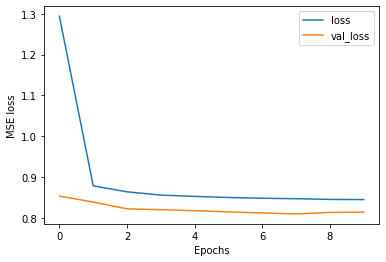

In [167]:
plt.plot(history['loss'], label = 'loss')
plt.plot(history['val_loss'], label = 'val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

In [ ]:
prediction=nn.predict([test_data.user_id, test_data.movie_id])
prediction

# Simple RNN

train dataset

In [ ]:
# train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=265)

dataset = tf.data.experimental.make_csv_dataset(
        "train_data.csv",
        batch_size=265,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=True,
    )

train_dataset = pd.read_csv("train_data.csv", sep='|', header=None)
train_dataset.head(5)

,0,1,2,3,4,5
0,u_1,"m_3186,m_1721,m_1270,m_1022,m_2340,m_1836,m_34...","4.0,4.0,5.0,5.0,3.0,5.0,4.0,4.0",F,g_1,occ_10
1,u_1,"m_2340,m_1836,m_3408,m_1207,m_2804,m_260,m_720...","3.0,5.0,4.0,4.0,5.0,4.0,3.0,5.0",F,g_1,occ_10
2,u_1,"m_2804,m_260,m_720,m_1193,m_919,m_608,m_2692,m...","5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0",F,g_1,occ_10
3,u_1,"m_919,m_608,m_2692,m_1961,m_2028,m_3105,m_938,...","4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0",F,g_1,occ_10
4,u_1,"m_1962,m_1028,m_2018,m_150,m_1097,m_914,m_1287...","4.0,5.0,4.0,5.0,4.0,3.0,5.0,4.0",F,g_1,occ_10


Create RNN Model

In [ ]:
hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3

inputs = my_model_inputs()
transformer_features, other_features = create_input_feature_encode(
inputs, include_user_id, include_user_features, include_movie_features
)
features = None
features = layers.Flatten()(transformer_features)

#Included the other features.
# if other_features is not None:
#     features = layers.concatenate(
#         [features, layers.Reshape([other_features.shape[-1]])(other_features)]
#     )

# for num_units in hidden_units:
num_units=128
features = layers.Embedding(input_dim=2, output_dim=num_units)(features)
# features = layers.GRU(num_units, return_sequences=True)(features)
features = layers.SimpleRNN(num_units)(features)

outputs = layers.Dense(units=1)(features)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_movie_id (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
movie_index_lookup (StringLooku multiple             0           target_movie_id[0][0]            
                                                                 seq_movie_id[0][0]               
__________________________________________________________________________________________________
movie_embedding (Embedding)     multiple             240746      movie_index_lookup[0][0]         
                                                                 movie_index_lookup[1][0]         
____________________________________________________________________________________________

training and evaluation

In [ ]:

model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01),loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=265)
history=model.fit(train_dataset, epochs=1).history
test_dataset = create_dataset("test_data.csv", batch_size=265)
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test MAE: {round(rmse, 3)}")

749/749 [==============================] - 301s 401ms/step - loss: 1.4108 - mean_absolute_error: 0.9731
Test MAE: 0.908


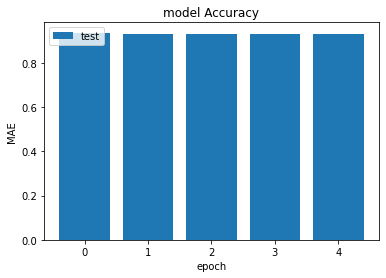

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(5), history['mean_absolute_error'])
# plt.plot(history.history["mean_absolute_error"])
plt.title("model Accuracy")
plt.ylabel("MAE")
plt.xlabel("epoch")
plt.legend(["test"], loc="upper left")
plt.show()

In [ ]:
prediction=model.predict(test_dataset)
prediction.sort()
prediction

array([[-0.01024882],
       [-0.01024882],
       [-0.01024882],
       ...,
       [-0.01024882],
       [-0.01024882],
       [-0.01024882]], dtype=float32)

In [ ]:
for i in test_dataset:
  print(i[0])
  print(i[1])
  # print(i[0]['target_movie_id'])
  # print(prediction[:265])
 
  break
     
i=0
user_movie_rating = dict()
for line in test_dataset:
  # for row in line:
  for user_id, movie_id, act_rating in zip(line[0]['user_id'], line[0]['target_movie_id'], line[1]):
    try:
      user_movie_rating[user_id.numpy().decode()].append((movie_id.numpy().decode(), act_rating.numpy(), prediction[i][0]))
    except KeyError:
      user_movie_rating[user_id.numpy().decode()] = [(movie_id.numpy().decode(), act_rating.numpy(), prediction[i][0])]
    i+=1  
  

In [ ]:
preds = []
for user, values in user_movie_rating.items():
  if len(values) > 5:
    for movie, rating, predicted in values:
      preds.append((user, movie, rating, predicted))

Create LSTM Model

In [ ]:
hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3

inputs = my_model_inputs()
transformer_features, other_features = create_input_feature_encode(
inputs, include_user_id, include_user_features, include_movie_features
)
features = None
features = layers.Flatten()(transformer_features)

# Included the other features.
if other_features is not None:
    features = layers.concatenate(
        [features, layers.Reshape([other_features.shape[-1]])(other_features)]
    )

# for num_units in hidden_units:
num_units=128
features = layers.Embedding(input_dim=2, output_dim=num_units)(features)
features = layers.LSTM(num_units)(features)

outputs = layers.Dense(units=1)(features)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Training and evaluation

In [ ]:
# Compile the model.
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01),loss=keras.losses.MeanSquaredError(),
metrics=[keras.metrics.MeanAbsoluteError()],)
# Read the training data.
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=265)
history=model.fit(train_dataset, epochs=5).history
# Read the test data.
test_dataset = create_dataset("test_data.csv", batch_size=265)
# Evaluate the model on the test data.
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test MAE: {round(rmse, 3)}")

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(5), history['mean_absolute_error'])
# plt.plot(history.history["mean_absolute_error"])
plt.title("model Accuracy")
plt.ylabel("MAE")
plt.xlabel("epoch")
plt.legend(["test"], loc="upper left")
plt.show()

cretae GRU model

In [ ]:
hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3

inputs = my_model_inputs()
transformer_features, other_features = create_input_feature_encode(
inputs, include_user_id, include_user_features, include_movie_features
)
features = None
features = layers.Flatten()(transformer_features)

# Included the other features.
if other_features is not None:
    features = layers.concatenate(
        [features, layers.Reshape([other_features.shape[-1]])(other_features)]
    )

# for num_units in hidden_units:
num_units=128
features = layers.Embedding(input_dim=1000, output_dim=num_units)(features)
features = layers.GRU(num_units, return_sequences=True)(features)
# features = layers.SimpleRNN(num_units)(features)

outputs = layers.Dense(units=1)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_movie_id (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
movie_index_lookup (StringLooku multiple             0           target_movie_id[0][0]            
                                                                 seq_movie_id[0][0]               
__________________________________________________________________________________________________
movie_embedding (Embedding)     multiple             240746      movie_index_lookup[0][0]         
                                                                 movie_index_lookup[1][0]         
____________________________________________________________________________________________

In [ ]:
hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3

inputs = my_model_inputs()
transformer_features, other_features = create_input_feature_encode(
inputs, include_user_id, include_user_features, include_movie_features
)
features = None
# features = layers.Flatten()(transformer_features)

# Included the other features.
# if other_features is not None:

#     features = layers.concatenate(
#         [features, layers.Reshape([other_features.shape[-1]])(other_features)]
#     )

# for num_units in hidden_units:
num_units=128
features = layers.Embedding(input_dim=2, output_dim=num_units)(features)
gru = layers.GRU(num_units, return_sequences=True)(features)
flatten=layers.Flatten()(gru)
# features = layers.SimpleRNN(num_units)(features)

outputs = layers.Dense(units=1)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Training and evaluation

In [ ]:
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01),loss=keras.losses.MeanSquaredError(),metrics=[keras.metrics.MeanAbsoluteError()],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=265)

history=model.fit(train_dataset, epochs=1).history
test_dataset = create_dataset("test_data.csv", batch_size=265)
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test MAE: {round(rmse, 3)}")

748/748 [==============================] - 356s 433ms/step - loss: 1.4705 - mean_absolute_error: 0.9835
Test MAE: 0.926


In [ ]:
prediction=model.predict(test_dataset)
prediction.sort()
prediction

array([[3.6123033],
       [3.6123033],
       [3.6123033],
       ...,
       [3.6123033],
       [3.6123033],
       [3.6123033]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(5), history['mean_absolute_error'])
# plt.plot(history.history["mean_absolute_error"])
plt.title("model Accuracy")
plt.ylabel("MAE")
plt.xlabel("epoch")
plt.legend(["test"], loc="upper left")
plt.show()

#Long short-term memory (LSTM)

In [ ]:
# Multi layer LSTM model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = concatenate([user_embed, movie_embed])

x = Dropout(0.75)(x)
BatchNormalization()
x = LSTM(70)(x)
x = Dropout(0.75)(x)
BatchNormalization()
x = Dense(1)(x)
LSTM_nn = Model([user_input, movie_input], x)
LSTM_nn.compile(Adam(0.001), loss='mse')

In [ ]:
LSTM_nn.compile(Adam(0.01),loss='mse',metrics=[keras.metrics.MeanAbsoluteError()],)

# Read the training data.
# train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
LSTM_nn.fit([train.user_id, train.movie_id], train.rating, batch_size=64, epochs=1,validation_data=([valid.user_id, valid.movie_id], valid.rating))



In [ ]:
prediction=LSTM_nn.predict([test_data_c.user_id, test_data_c.movie_id])
prediction

In [ ]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(LSTM_history.history['loss'], label = 'LSTMloss')
plt.plot(LSTM_history.history['val_loss'], label = 'LSTMval_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

Multilayer LSTM

In [ ]:
# Multi layer LSTM model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = concatenate([user_embed, movie_embed])

x = Dropout(0.75)(x)
BatchNormalization()
x = LSTM(50)(x)
x = Dropout(0.75)(x)
BatchNormalization()
x = Dense(1)(x)
LSTM50_nn = Model([user_input, movie_input], x)
LSTM50_nn.compile(Adam(0.001), loss='mse')

In [ ]:
LSTM50_nn.compile(Adam(0.01),loss='mse',metrics=[keras.metrics.MeanAbsoluteError()],)

# Read the training data.
# train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
LSTM50_nn.fit([train.user_id, train.movie_id], train.rating, batch_size=64, epochs=1)



In [ ]:

prediction=LSTM50_nn.predict([test_data_c.user_id, test_data_c.movie_id])
prediction

#Gated Recurrent Unit(GRU)

In [ ]:
# Multi layer GRU model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = concatenate([user_embed, movie_embed])

x = Dropout(0.3)(x)
x = GRU(70)(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
GRU_nn = Model([user_input, movie_input], x)
# GRU_nn.compile(Adam(0.001), loss='mse')

In [ ]:
GRU_nn.compile(Adam(0.01),loss='mse',metrics=[keras.metrics.MeanAbsoluteError()],)

# Read the training data.
# train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
history=GRU_nn.fit([train.user_id, train.movie_id], train.rating, batch_size=64, epochs=5,validation_data=([valid.user_id, valid.movie_id], valid.rating)).history



In [ ]:
prediction=GRU_nn.predict([test_data_c.user_id, test_data_c.movie_id])
prediction

Well this is horribly worse than my dense layer. Let's try increasing the complexity of the model. 

In [ ]:
# Multi layer GRU model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = concatenate([user_embed, movie_embed])

x = Dropout(0.3)(x)
x = GRU(70)(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
GRU_nn = Model([user_input, movie_input], x)
# GRU_nn.compile(Adam(0.001), loss='mse')

In [ ]:
GRU_nn.compile(Adam(0.01),loss='mse',metrics=[keras.metrics.MeanAbsoluteError()],)

# Read the training data.
# train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
GRU_nn.fit([train.user_id, train.movie_id], train.rating, batch_size=64, epochs=1)



In [ ]:
prediction=GRU_nn.predict([test_data_c.user_id, test_data_c.movie_id])
prediction

In [ ]:
plt.clf()
plt.plot(nn_history.history['loss'], label = 'nn_loss')
plt.plot(nn_history.history['val_loss'], label = 'nn_val_loss')
plt.plot(GRUnn_history.history['loss'], label = 'GRUloss')
plt.plot(GRUnn_history.history['val_loss'], label = 'GRUval_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

bi-directional GRU layer

In [ ]:
# Multi layer bi-directional GRU model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = concatenate([user_embed, movie_embed])

x = Dropout(0.3)(x)
x_fwd = GRU(70)(x)
x_bwd = GRU(70, go_backwards = True)(x)
x_bdir = concatenate([x_fwd, x_bwd])
# x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
x = Dense(1)(x)
GRU_bdir = Model([user_input, movie_input], x)
# GRU_bdir.compile(Adam(0.001), loss='mse')

In [ ]:
GRU_bdir.compile(Adam(0.01),loss='mse',metrics=[keras.metrics.MeanAbsoluteError()],)

# Read the training data.
# train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
GRU_bdir.fit([train.user_id, train.movie_id], train.rating, batch_size=64, epochs=1)



In [ ]:
prediction=GRU_bdir.predict([test_data_c.user_id, test_data_c.movie_id])
prediction

In [ ]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(nn_history.history['loss'], label = 'nn_loss')
plt.plot(nn_history.history['val_loss'], label = 'nn_val_loss')
plt.plot(GRUbdir_history.history['loss'], label = 'GRUloss')
plt.plot(GRUbdir_history.history['val_loss'], label = 'GRUval_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

#Transformer Model

Create Model

In [45]:
include_user_id = False;include_user_features = False;include_movie_features = False
hidden_units = [256, 128];dropout_rate = 0.1;num_heads = 8
def create_model():
    inputs = my_model_inputs()
    transformer_features, other_features = create_input_feature_encode( inputs, include_user_id, include_user_features, include_movie_features)
    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)
    # Transformer block.
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    z1 = layers.Add()([transformer_features, attention_output])
    z1 = layers.LayerNormalization()(z1)
    z2 = layers.LeakyReLU()(z1)
    z2 = layers.Dense(units=z2.shape[-1])(z2)
    z2 = layers.Dropout(dropout_rate)(z2)
    transformer_features = layers.Add()([z1, z2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)
    # Included the other features.
    if other_features is not None:
        features = layers.concatenate([features, layers.Reshape([other_features.shape[-1]])(other_features)])
    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
model = create_model()

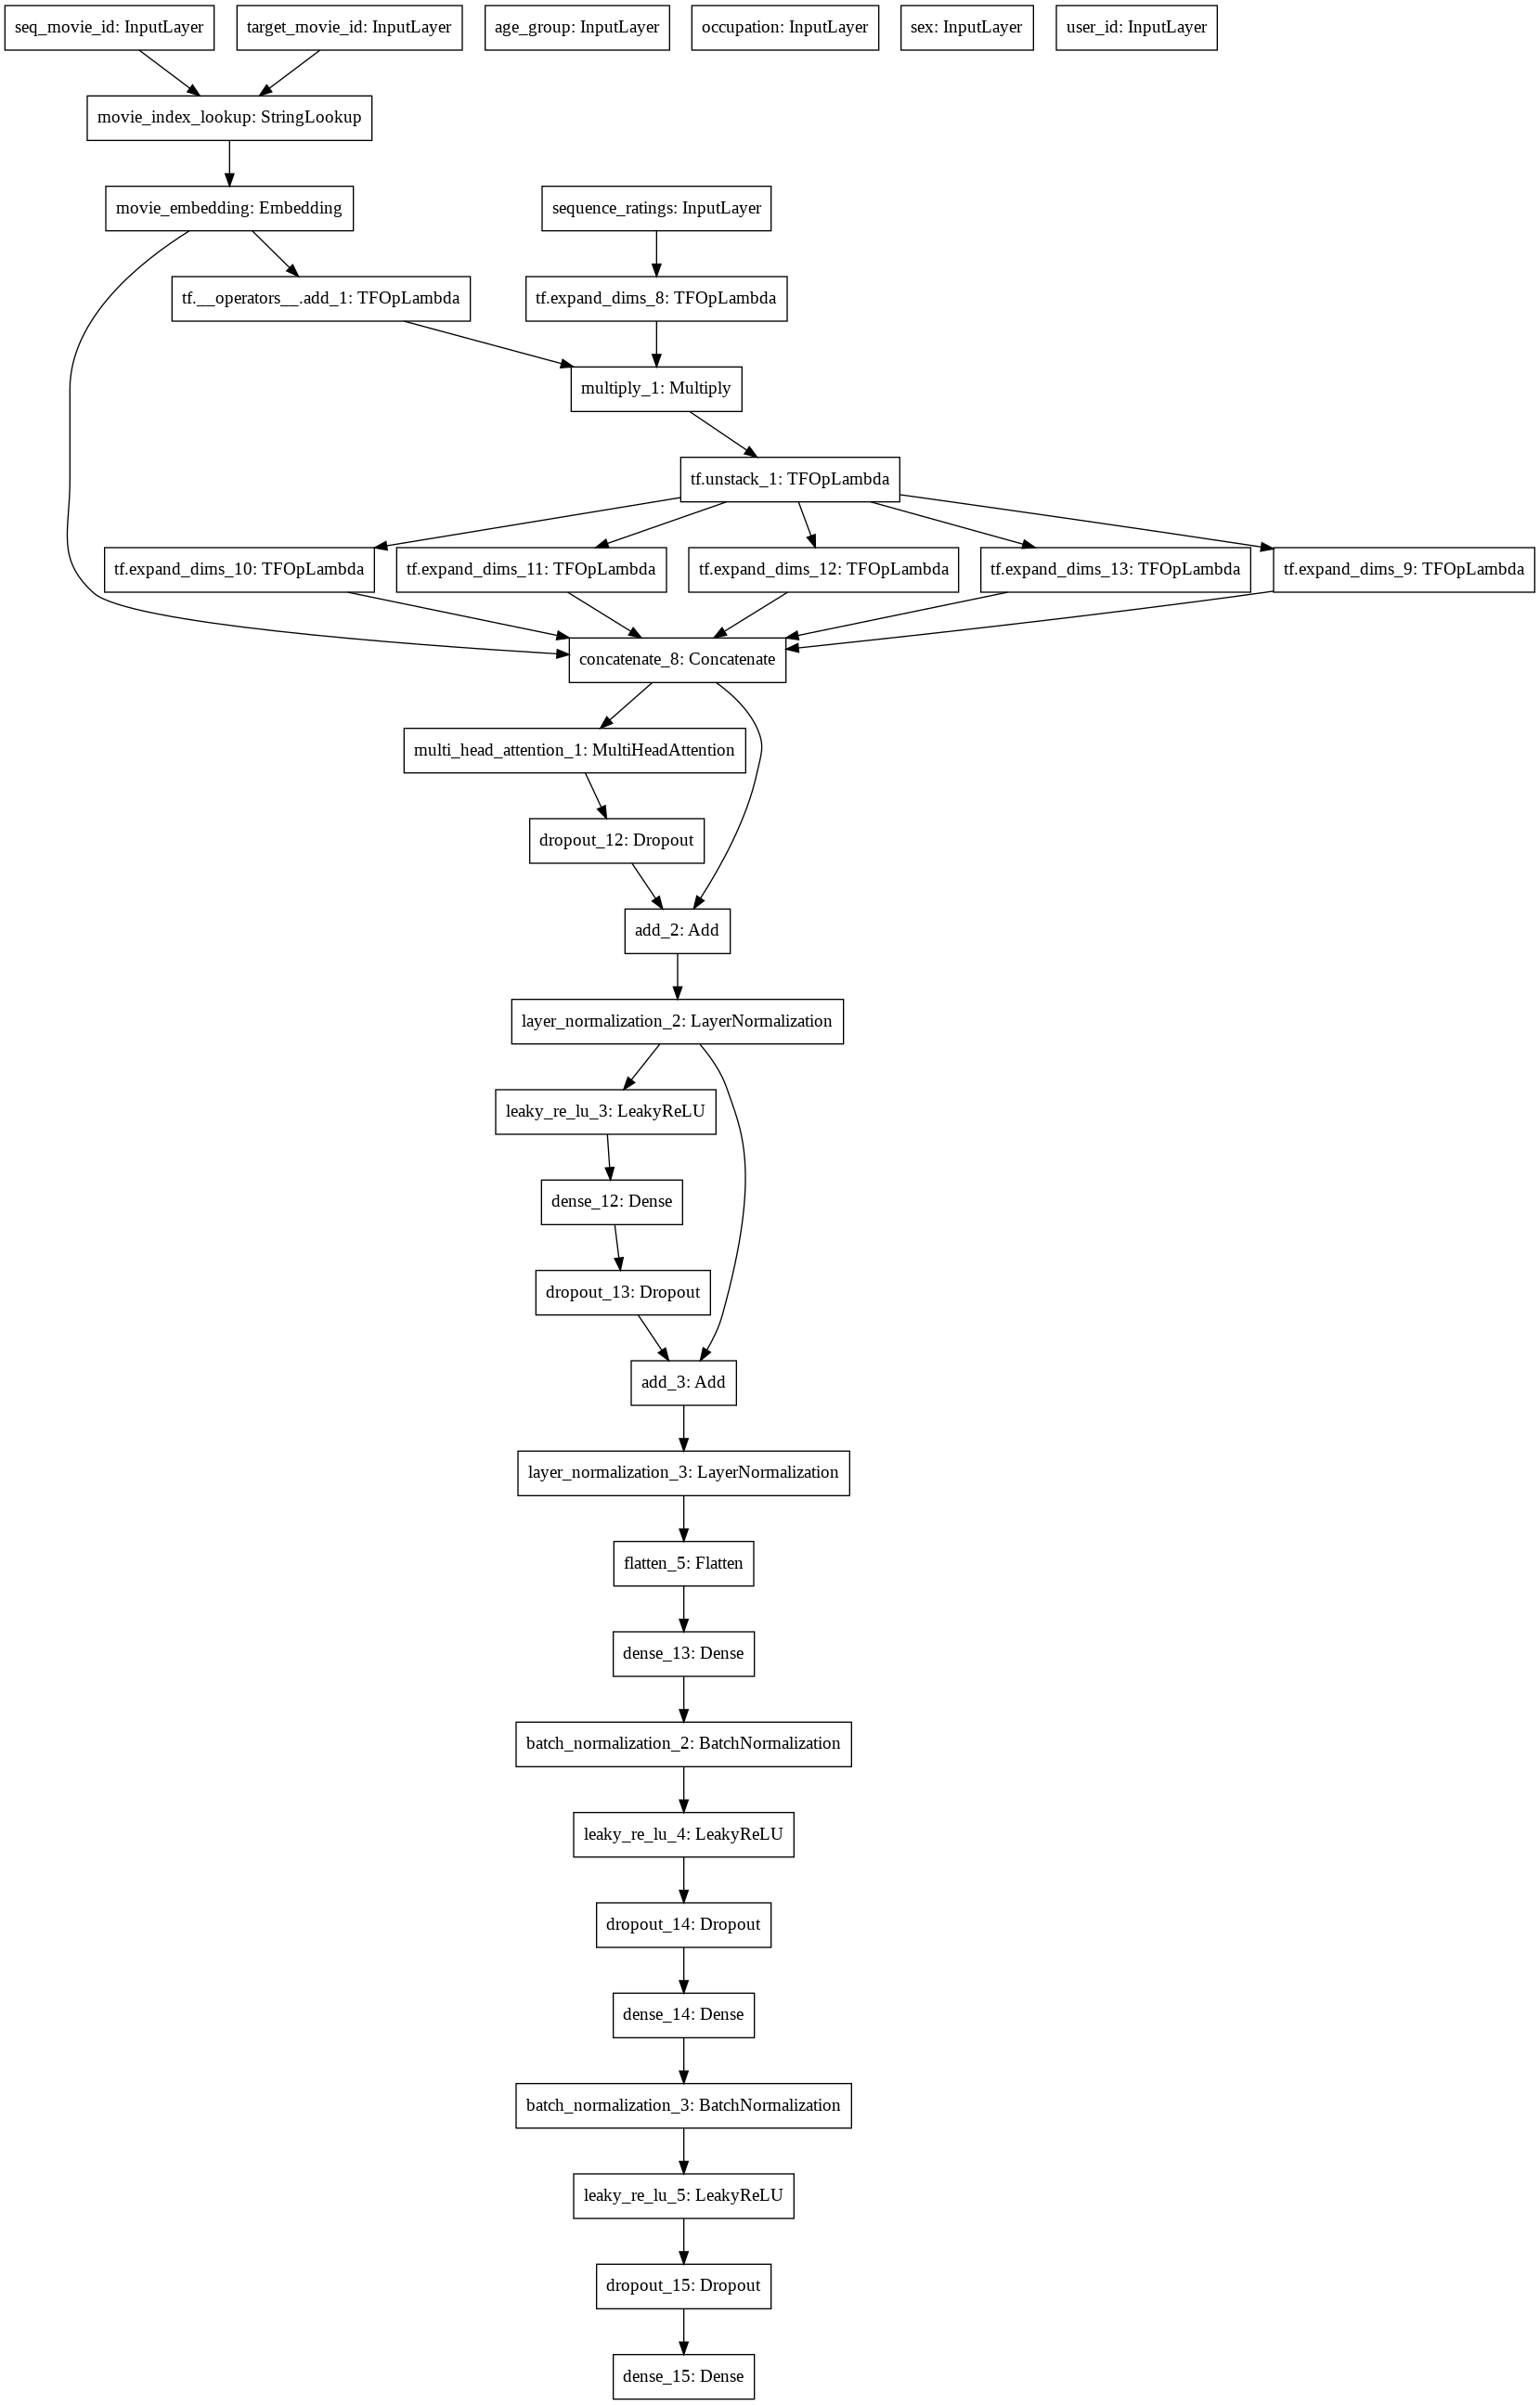

In [307]:
tf.keras.utils.plot_model(model, to_file='Model1.png')

training and evaluation

In [46]:
# Compile the model.
from keras import metrics
from keras.callbacks import EarlyStopping
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
 
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=265)
es=EarlyStopping(monitor='loss', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
history=model.fit(train_dataset, epochs=5,callbacks=[es]).history
# history=model.fit(train_dataset, epochs=10).history
test_dataset = create_dataset("test_data.csv", batch_size=265)
#_, train_mse = model.evaluate(train_dataset, verbose=0)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))
# print('Test: %.3f' % (test_mse))

# es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
# train
# history=model.fit(x=[df.user_id, df.movie_id], y=df.y, batch_size=500,epochs=20, verbose=1, validation_split=0.15, callbacks=[es])

Epoch 1/5
1433/1433 [==============================] - 275s 190ms/step - loss: 1.6172 - MAE: 0.9883 - rmse: 1.2200
Epoch 2/5
1433/1433 [==============================] - 272s 190ms/step - loss: 1.0498 - MAE: 0.8176 - rmse: 1.0234
Epoch 3/5
1433/1433 [==============================] - 260s 182ms/step - loss: 0.9518 - MAE: 0.7775 - rmse: 0.9745
Epoch 4/5
1433/1433 [==============================] - 261s 182ms/step - loss: 0.8966 - MAE: 0.7529 - rmse: 0.9458
Epoch 5/5
1433/1433 [==============================] - 266s 185ms/step - loss: 0.8619 - MAE: 0.7376 - rmse: 0.9273
Test rmse: 0.945 Test mae: 0.762


In [164]:
from keras import metrics
from keras.callbacks import EarlyStopping
from keras import backend
# from keras import backend as
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=50)
hd1=model.fit(train_dataset, epochs=15)
test_dataset = create_dataset("test_data.csv", batch_size=50)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))

Epoch 1/15
7596/7596 [==============================] - 53s 7ms/step - loss: 0.8833 - MAE: 0.7483 - rmse: 0.9348
Epoch 2/15
7596/7596 [==============================] - 52s 7ms/step - loss: 0.8163 - MAE: 0.7180 - rmse: 0.8983
Epoch 3/15
7596/7596 [==============================] - 52s 7ms/step - loss: 0.7888 - MAE: 0.7050 - rmse: 0.8831
Epoch 4/15
7596/7596 [==============================] - 51s 7ms/step - loss: 0.7698 - MAE: 0.6967 - rmse: 0.8724
Epoch 5/15
7596/7596 [==============================] - 52s 7ms/step - loss: 0.7543 - MAE: 0.6896 - rmse: 0.8637
Epoch 6/15
7596/7596 [==============================] - 51s 7ms/step - loss: 0.7441 - MAE: 0.6845 - rmse: 0.8578
Epoch 7/15
7596/7596 [==============================] - 51s 7ms/step - loss: 0.7333 - MAE: 0.6792 - rmse: 0.8516
Epoch 8/15
7596/7596 [==============================] - 51s 7ms/step - loss: 0.7233 - MAE: 0.6745 - rmse: 0.8456
Epoch 9/15
7596/7596 [==============================] - 51s 7ms/step - loss: 0.7117 - MAE: 0.668

In [169]:
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=50)
hd3=model.fit(train_dataset, epochs=15)
# Read the test data.
test_dataset = create_dataset("test_data.csv", batch_size=50)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))

Epoch 1/15
7596/7596 [==============================] - 57s 7ms/step - loss: 1.2697 - MAE: 0.8924 - rmse: 1.1064
Epoch 2/15
7596/7596 [==============================] - 54s 7ms/step - loss: 0.9177 - MAE: 0.7628 - rmse: 0.9528
Epoch 3/15
7596/7596 [==============================] - 54s 7ms/step - loss: 0.8607 - MAE: 0.7374 - rmse: 0.9226
Epoch 4/15
7596/7596 [==============================] - 55s 7ms/step - loss: 0.8325 - MAE: 0.7246 - rmse: 0.9071
Epoch 5/15
7596/7596 [==============================] - 54s 7ms/step - loss: 0.8136 - MAE: 0.7160 - rmse: 0.8969
Epoch 6/15
7596/7596 [==============================] - 53s 7ms/step - loss: 0.8011 - MAE: 0.7106 - rmse: 0.8899
Epoch 7/15
7596/7596 [==============================] - 53s 7ms/step - loss: 0.7875 - MAE: 0.7041 - rmse: 0.8824
Epoch 8/15
7596/7596 [==============================] - 55s 7ms/step - loss: 0.7781 - MAE: 0.6991 - rmse: 0.8771
Epoch 9/15
7596/7596 [==============================] - 57s 7ms/step - loss: 0.7678 - MAE: 0.694

In [172]:
from keras import metrics
from keras.callbacks import EarlyStopping
from keras import backend
# from keras import backend as
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=50)
hd5=model.fit(train_dataset, epochs=15)
test_dataset = create_dataset("test_data.csv", batch_size=50)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))

Epoch 1/15
7596/7596 [==============================] - 57s 7ms/step - loss: 1.3533 - MAE: 0.9120 - rmse: 1.1286
Epoch 2/15
7596/7596 [==============================] - 56s 7ms/step - loss: 0.9306 - MAE: 0.7683 - rmse: 0.9594
Epoch 3/15
7596/7596 [==============================] - 56s 7ms/step - loss: 0.8698 - MAE: 0.7418 - rmse: 0.9275
Epoch 4/15
7596/7596 [==============================] - 56s 7ms/step - loss: 0.8390 - MAE: 0.7277 - rmse: 0.9108
Epoch 5/15
7596/7596 [==============================] - 56s 7ms/step - loss: 0.8184 - MAE: 0.7190 - rmse: 0.8997
Epoch 6/15
7596/7596 [==============================] - 56s 7ms/step - loss: 0.8043 - MAE: 0.7123 - rmse: 0.8919
Epoch 7/15
7596/7596 [==============================] - 56s 7ms/step - loss: 0.7929 - MAE: 0.7069 - rmse: 0.8854
Epoch 8/15
7596/7596 [==============================] - 56s 7ms/step - loss: 0.7830 - MAE: 0.7017 - rmse: 0.8798
Epoch 9/15
7596/7596 [==============================] - 58s 8ms/step - loss: 0.7726 - MAE: 0.697

In [177]:
from keras import metrics
from keras.callbacks import EarlyStopping
from keras import backend
# from keras import backend as
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=50)
hd8=model.fit(train_dataset, epochs=15)
test_dataset = create_dataset("test_data.csv", batch_size=50)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))

Epoch 1/15
7596/7596 [==============================] - 60s 8ms/step - loss: 1.2979 - MAE: 0.9000 - rmse: 1.1147
Epoch 2/15
7596/7596 [==============================] - 58s 8ms/step - loss: 0.9325 - MAE: 0.7683 - rmse: 0.9605
Epoch 3/15
7596/7596 [==============================] - 59s 8ms/step - loss: 0.8668 - MAE: 0.7409 - rmse: 0.9261
Epoch 4/15
7596/7596 [==============================] - 59s 8ms/step - loss: 0.8385 - MAE: 0.7270 - rmse: 0.9107
Epoch 5/15
7596/7596 [==============================] - 60s 8ms/step - loss: 0.8171 - MAE: 0.7179 - rmse: 0.8989
Epoch 6/15
7596/7596 [==============================] - 59s 8ms/step - loss: 0.8027 - MAE: 0.7113 - rmse: 0.8909
Epoch 7/15
7596/7596 [==============================] - 57s 7ms/step - loss: 0.7899 - MAE: 0.7053 - rmse: 0.8840
Epoch 8/15
7596/7596 [==============================] - 57s 8ms/step - loss: 0.7806 - MAE: 0.7007 - rmse: 0.8785
Epoch 9/15
7596/7596 [==============================] - 58s 8ms/step - loss: 0.7698 - MAE: 0.695

<Figure size 432x288 with 0 Axes>

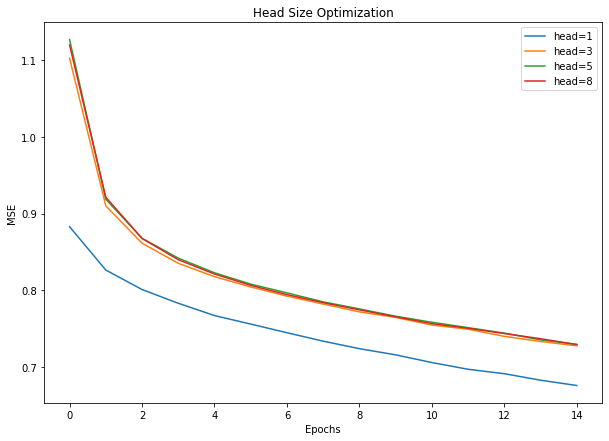

In [178]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(hd1.history['loss'], label = 'head=1')
plt.plot(hd3.history['loss'], label = 'head=3')
plt.plot(hd5.history['loss'], label = 'head=5')
plt.plot(hd8.history['loss'], label = 'head=8')
plt.legend()
plt.title('Head Size Optimization')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

<Figure size 432x288 with 0 Axes>

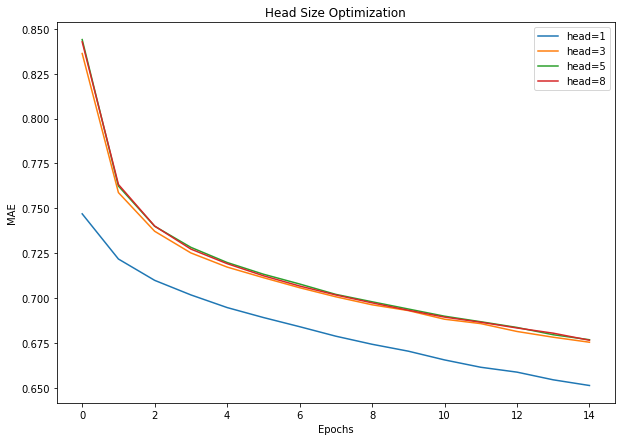

In [180]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(hd1.history['MAE'], label = 'head=1')
plt.plot(hd3.history['MAE'], label = 'head=3')
plt.plot(hd5.history['MAE'], label = 'head=5')
plt.plot(hd8.history['MAE'], label = 'head=8')
plt.legend()
plt.title('Head Size Optimization')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

<Figure size 432x288 with 0 Axes>

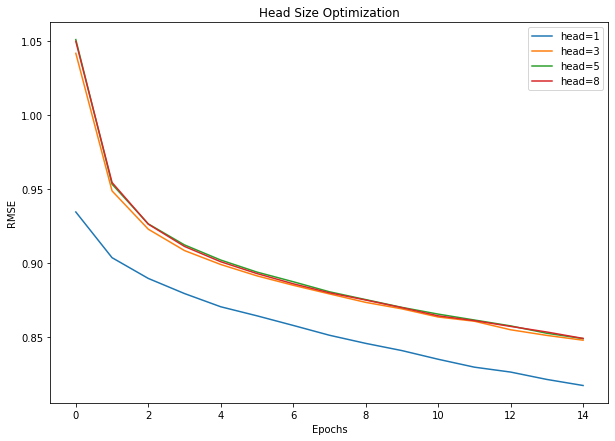

In [181]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(hd1.history['rmse'], label = 'head=1')
plt.plot(hd3.history['rmse'], label = 'head=3')
plt.plot(hd5.history['rmse'], label = 'head=5')
plt.plot(hd8.history['rmse'], label = 'head=8')
plt.legend()
plt.title('Head Size Optimization')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

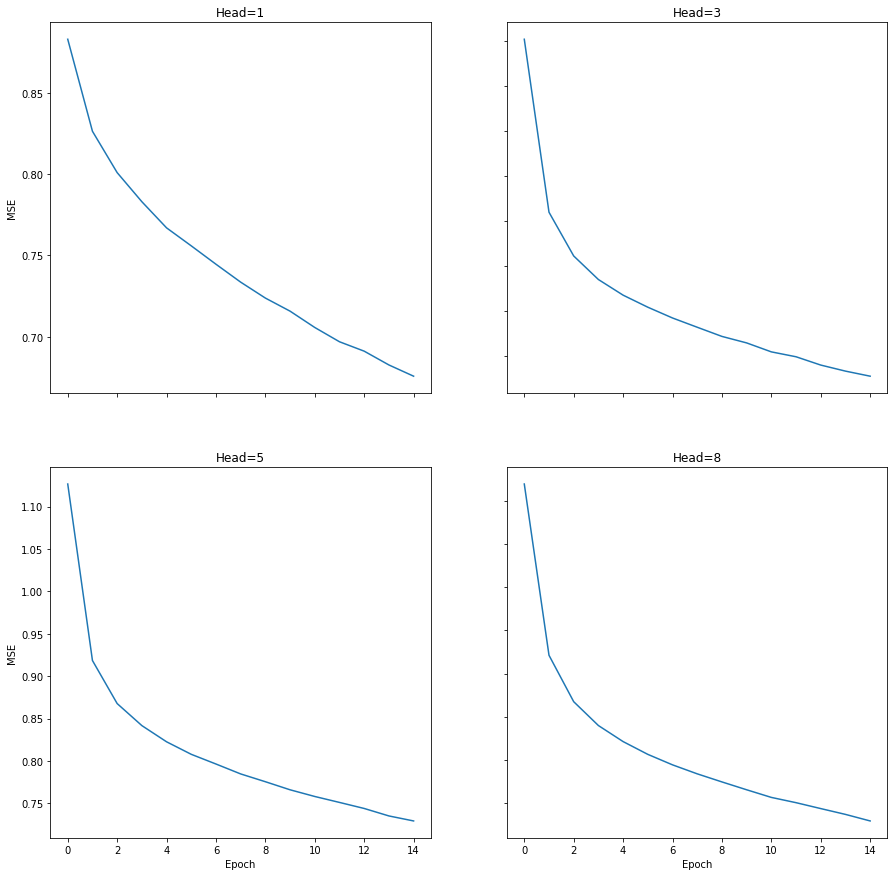

In [179]:
# f = plt.figure(figsize=(10,3))
f, axarr = plt.subplots(2, 2,figsize=(15,15))
fig.suptitle('Head Size Optimization')
axarr[0, 0].plot(hd1.history['loss'])
axarr[0, 0].set_title('Head=1')
axarr[0, 1].plot(hd3.history['loss'])
axarr[0, 1].set_title('Head=3')
axarr[1, 0].plot(hd5.history['loss'])
axarr[1, 0].set_title('Head=5')
axarr[1, 1].plot(hd8.history['loss'])
axarr[1, 1].set_title('Head=8')
for ax in axarr.flat:
    ax.set(xlabel='Epoch', ylabel='MSE')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()

In [47]:
from keras import metrics
from keras.callbacks import EarlyStopping
from keras import backend
# from keras import backend as
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=20)
# Fit the model with the training data.
h1=model.fit(train_dataset, epochs=15)
# Read the test data.
test_dataset = create_dataset("test_data.csv", batch_size=20)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))


Epoch 1/15
18977/18977 [==============================] - 123s 6ms/step - loss: 0.9424 - MAE: 0.7746 - rmse: 0.9585
Epoch 2/15
18977/18977 [==============================] - 120s 6ms/step - loss: 0.8514 - MAE: 0.7341 - rmse: 0.9104
Epoch 3/15
18977/18977 [==============================] - 119s 6ms/step - loss: 0.8291 - MAE: 0.7241 - rmse: 0.8982
Epoch 4/15
18977/18977 [==============================] - 119s 6ms/step - loss: 0.8146 - MAE: 0.7175 - rmse: 0.8903
Epoch 5/15
18977/18977 [==============================] - 118s 6ms/step - loss: 0.8017 - MAE: 0.7114 - rmse: 0.8831
Epoch 6/15
18977/18977 [==============================] - 118s 6ms/step - loss: 0.7919 - MAE: 0.7072 - rmse: 0.8777
Epoch 7/15
18977/18977 [==============================] - 118s 6ms/step - loss: 0.7855 - MAE: 0.7045 - rmse: 0.8742
Epoch 8/15
18977/18977 [==============================] - 117s 6ms/step - loss: 0.7739 - MAE: 0.6990 - rmse: 0.8673
Epoch 9/15
18977/18977 [==============================] - 117s 6ms/step 

<Figure size 432x288 with 0 Axes>

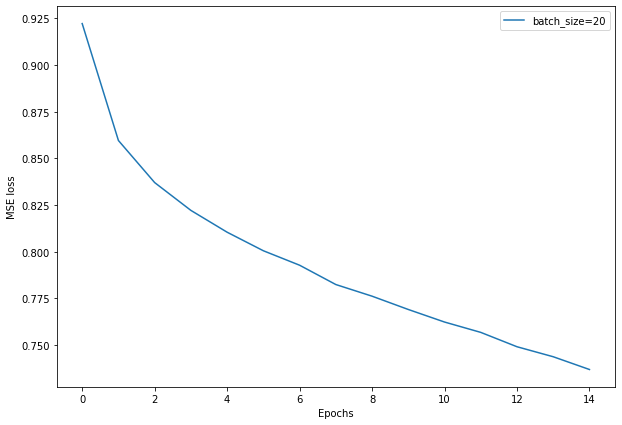

In [55]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(h1.history['loss'], label = 'batch_size=20')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

<Figure size 432x288 with 0 Axes>

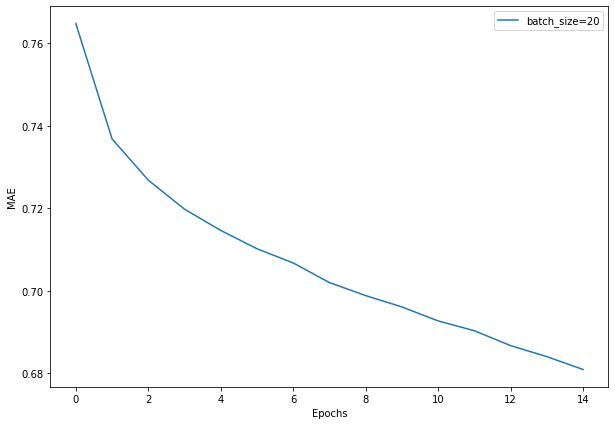

In [110]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(h1.history['MAE'], label = 'batch_size=20')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [72]:
from keras import metrics
from keras.callbacks import EarlyStopping
from keras import backend
# from keras import backend as
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=50)
# Fit the model with the training data.
h2=model.fit(train_dataset, epochs=15)
# Read the test data.
test_dataset = create_dataset("test_data.csv", batch_size=50)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))

Epoch 1/15
7591/7591 [==============================] - 54s 7ms/step - loss: 1.1286 - MAE: 0.8493 - rmse: 1.0562
Epoch 2/15
7591/7591 [==============================] - 52s 7ms/step - loss: 0.8978 - MAE: 0.7544 - rmse: 0.9425
Epoch 3/15
7591/7591 [==============================] - 52s 7ms/step - loss: 0.8467 - MAE: 0.7306 - rmse: 0.9150
Epoch 4/15
7591/7591 [==============================] - 52s 7ms/step - loss: 0.8208 - MAE: 0.7193 - rmse: 0.9010
Epoch 5/15
7591/7591 [==============================] - 53s 7ms/step - loss: 0.8047 - MAE: 0.7120 - rmse: 0.8920
Epoch 6/15
7591/7591 [==============================] - 52s 7ms/step - loss: 0.7907 - MAE: 0.7058 - rmse: 0.8841
Epoch 7/15
7591/7591 [==============================] - 52s 7ms/step - loss: 0.7781 - MAE: 0.6992 - rmse: 0.8770
Epoch 8/15
7591/7591 [==============================] - 53s 7ms/step - loss: 0.7691 - MAE: 0.6960 - rmse: 0.8722
Epoch 9/15
7591/7591 [==============================] - 55s 7ms/step - loss: 0.7581 - MAE: 0.690

<Figure size 432x288 with 0 Axes>

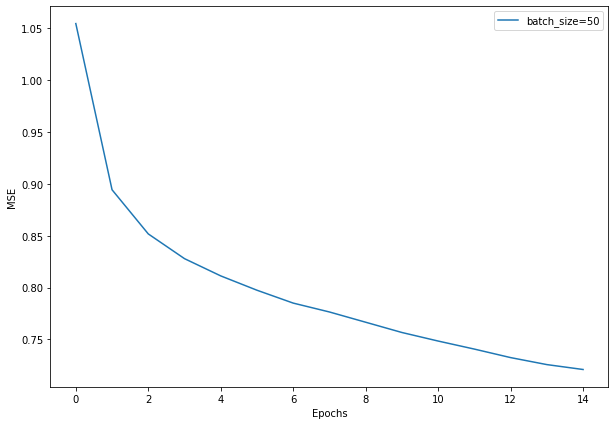

In [117]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(h2.history['loss'], label = 'batch_size=50')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [92]:
from keras import metrics
from keras.callbacks import EarlyStopping
from keras import backend
# from keras import backend as
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=100)
# Fit the model with the training data.
h3=model.fit(train_dataset, epochs=15)
# Read the test data.
test_dataset = create_dataset("test_data.csv", batch_size=100)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))

Epoch 1/15
3796/3796 [==============================] - 33s 8ms/step - loss: 1.4627 - MAE: 0.9444 - rmse: 1.1664
Epoch 2/15
3796/3796 [==============================] - 32s 8ms/step - loss: 0.9565 - MAE: 0.7788 - rmse: 0.9753
Epoch 3/15
3796/3796 [==============================] - 32s 8ms/step - loss: 0.8832 - MAE: 0.7468 - rmse: 0.9372
Epoch 4/15
3796/3796 [==============================] - 31s 8ms/step - loss: 0.8472 - MAE: 0.7313 - rmse: 0.9179
Epoch 5/15
3796/3796 [==============================] - 31s 8ms/step - loss: 0.8217 - MAE: 0.7201 - rmse: 0.9039
Epoch 6/15
3796/3796 [==============================] - 32s 8ms/step - loss: 0.8073 - MAE: 0.7136 - rmse: 0.8959
Epoch 7/15
3796/3796 [==============================] - 33s 9ms/step - loss: 0.7939 - MAE: 0.7074 - rmse: 0.8884
Epoch 8/15
3796/3796 [==============================] - 33s 9ms/step - loss: 0.7801 - MAE: 0.7010 - rmse: 0.8809
Epoch 9/15
3796/3796 [==============================] - 32s 8ms/step - loss: 0.7700 - MAE: 0.696

<Figure size 432x288 with 0 Axes>

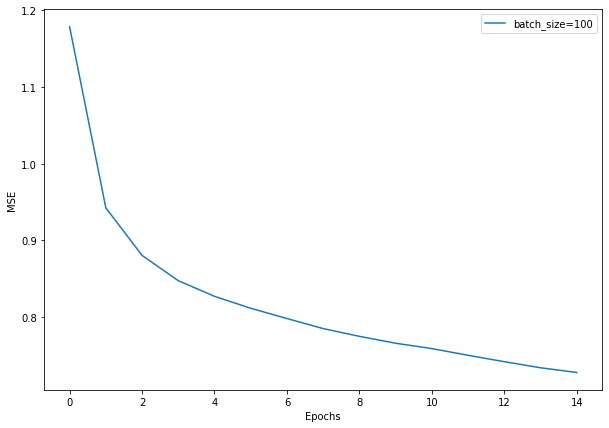

In [94]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(h3.history['loss'], label = 'batch_size=100')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [67]:
from keras import metrics
from keras.callbacks import EarlyStopping
from keras import backend
# from keras import backend as
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=260)
# Fit the model with the training data.
h4=model.fit(train_dataset, epochs=15)
# Read the test data.
test_dataset = create_dataset("test_data.csv", batch_size=260)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))

Epoch 1/15
1460/1460 [==============================] - 17s 11ms/step - loss: 1.4771 - MAE: 0.9560 - rmse: 1.1839
Epoch 2/15
1460/1460 [==============================] - 16s 11ms/step - loss: 1.0169 - MAE: 0.8046 - rmse: 1.0074
Epoch 3/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.9233 - MAE: 0.7653 - rmse: 0.9599
Epoch 4/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.8756 - MAE: 0.7446 - rmse: 0.9348
Epoch 5/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.8468 - MAE: 0.7310 - rmse: 0.9193
Epoch 6/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.8266 - MAE: 0.7223 - rmse: 0.9081
Epoch 7/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.8127 - MAE: 0.7163 - rmse: 0.9005
Epoch 8/15
1460/1460 [==============================] - 15s 11ms/step - loss: 0.7980 - MAE: 0.7092 - rmse: 0.8922
Epoch 9/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.7894 - M

In [59]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), ))
model.compile( optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics=['MAE',rmse],)
train_dataset = create_dataset("train_data.csv", shuffle=True, batch_size=260)
# Fit the model with the training data.
h4=model.fit(train_dataset, epochs=15)
# Read the test data.
test_dataset = create_dataset("test_data.csv", batch_size=260)
_, test_mse,tr = model.evaluate(test_dataset, verbose=0)
print('Test rmse: %.3f' % (tr), 'Test mae: %.3f' % (test_mse))

Epoch 1/15
1460/1460 [==============================] - 17s 11ms/step - loss: 0.6116 - MAE: 0.6187 - rmse: 0.7811
Epoch 2/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.6088 - MAE: 0.6170 - rmse: 0.7793
Epoch 3/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.6013 - MAE: 0.6134 - rmse: 0.7744
Epoch 4/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.5975 - MAE: 0.6111 - rmse: 0.7720
Epoch 5/15
1460/1460 [==============================] - 16s 11ms/step - loss: 0.5925 - MAE: 0.6089 - rmse: 0.7688
Epoch 6/15
1460/1460 [==============================] - 15s 10ms/step - loss: 0.5872 - MAE: 0.6061 - rmse: 0.7654
Epoch 7/15
1460/1460 [==============================] - 15s 11ms/step - loss: 0.5816 - MAE: 0.6031 - rmse: 0.7618
Epoch 8/15
1460/1460 [==============================] - 15s 11ms/step - loss: 0.5775 - MAE: 0.6010 - rmse: 0.7590
Epoch 9/15
1460/1460 [==============================] - 15s 10ms/step - loss: 0.5736 - M

<Figure size 432x288 with 0 Axes>

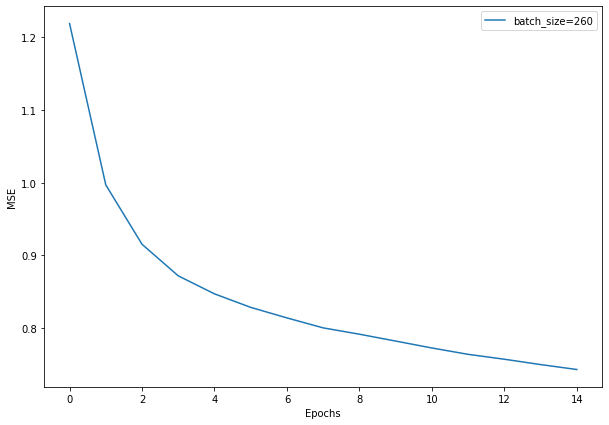

In [118]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(h4.history['loss'], label = 'batch_size=260')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

<Figure size 432x288 with 0 Axes>

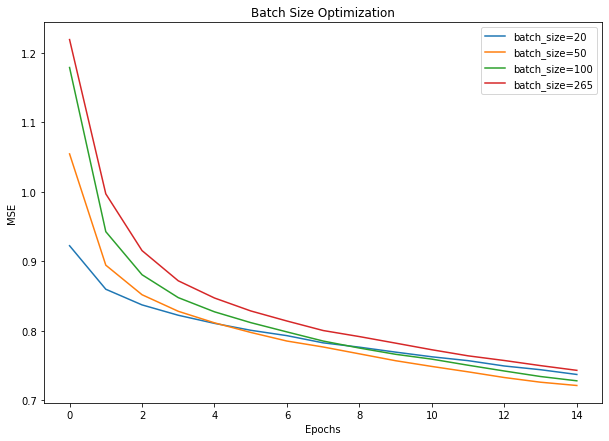

In [93]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(h1.history['loss'], label = 'batch_size=20')
plt.plot(h2.history['loss'], label = 'batch_size=50')
plt.plot(h3.history['loss'], label = 'batch_size=100')
plt.plot(h4.history['loss'], label = 'batch_size=265')
plt.legend()
plt.title('Batch Size Optimization')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

<Figure size 432x288 with 0 Axes>

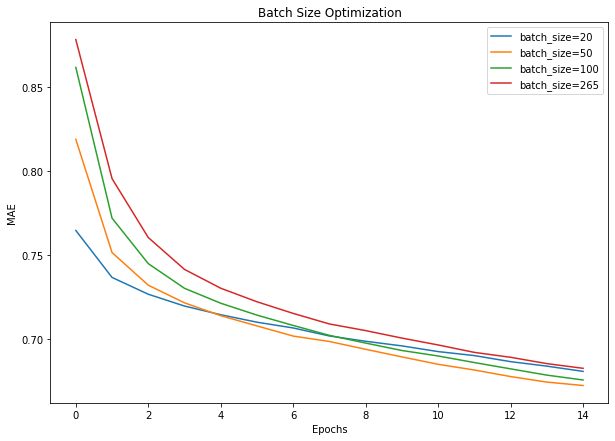

In [111]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(h1.history['MAE'], label = 'batch_size=20')
plt.plot(h2.history['MAE'], label = 'batch_size=50')
plt.plot(h3.history['MAE'], label = 'batch_size=100')
plt.plot(h4.history['MAE'], label = 'batch_size=265')
plt.legend()
plt.title('Batch Size Optimization')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

<Figure size 432x288 with 0 Axes>

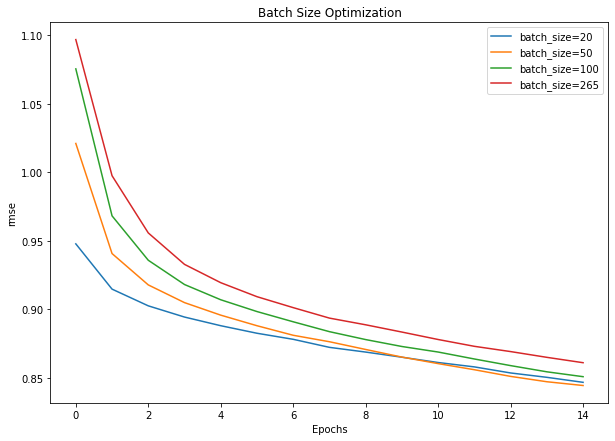

In [115]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(h1.history['rmse'], label = 'batch_size=20')
plt.plot(h2.history['rmse'], label = 'batch_size=50')
plt.plot(h3.history['rmse'], label = 'batch_size=100')
plt.plot(h4.history['rmse'], label = 'batch_size=265')
plt.legend()
plt.title('Batch Size Optimization')
plt.xlabel('Epochs')
plt.ylabel('rmse')
plt.show()

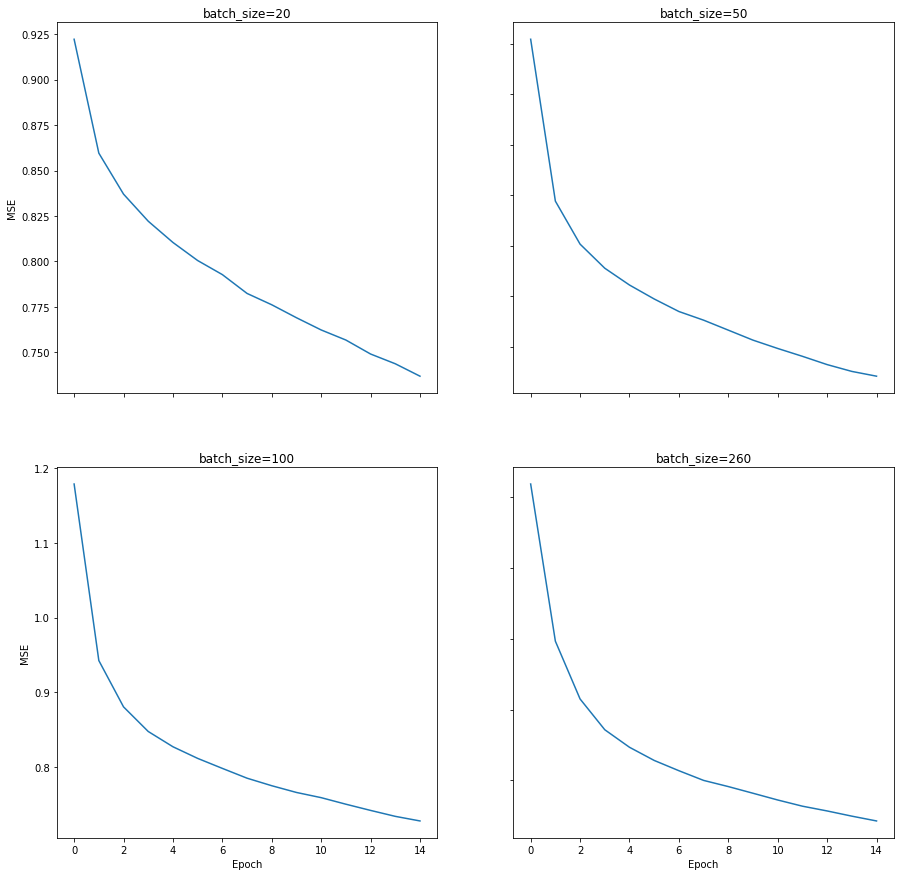

In [108]:
# f = plt.figure(figsize=(10,3))
f, axarr = plt.subplots(2, 2,figsize=(15,15))
fig.suptitle('Batch Size Optimization')
axarr[0, 0].plot(h1.history['loss'])
axarr[0, 0].set_title('batch_size=20')
axarr[0, 1].plot(h2.history['loss'])
axarr[0, 1].set_title('batch_size=50')
axarr[1, 0].plot(h3.history['loss'])
axarr[1, 0].set_title('batch_size=100')
axarr[1, 1].plot(h4.history['loss'])
axarr[1, 1].set_title('batch_size=260')
for ax in axarr.flat:
    ax.set(xlabel='Epoch', ylabel='MSE')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()

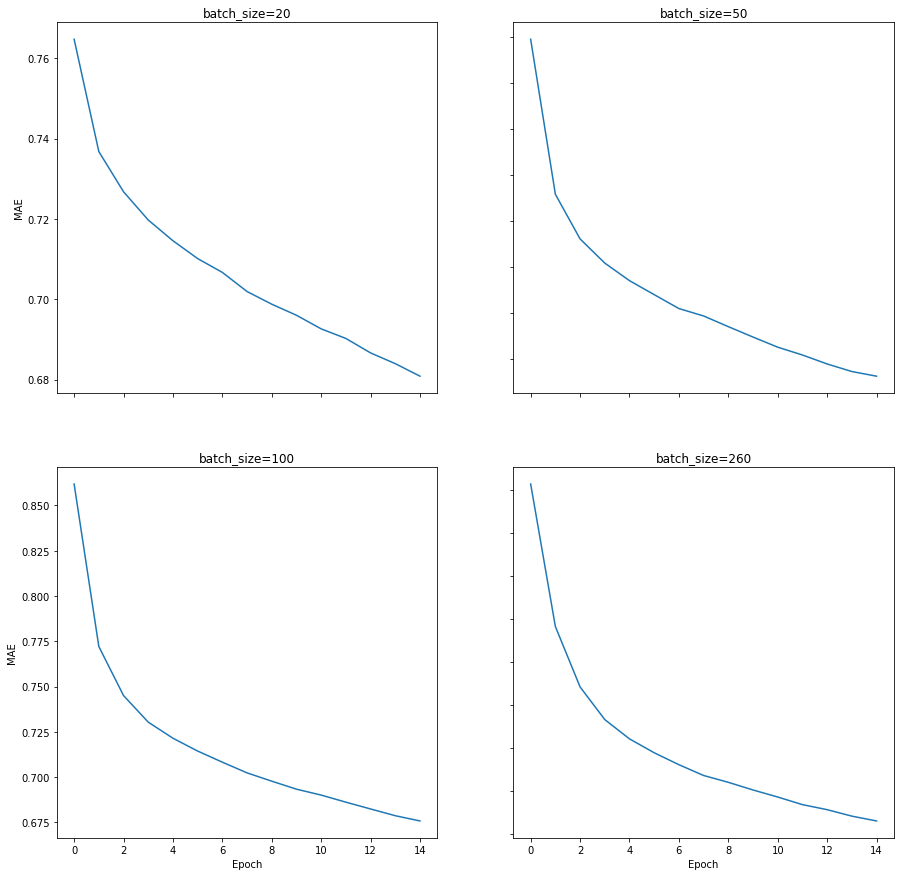

In [112]:
# f = plt.figure(figsize=(10,3))
f, axarr = plt.subplots(2, 2,figsize=(15,15))
fig.suptitle('Batch Size Optimization')
axarr[0, 0].plot(h1.history['MAE'])
axarr[0, 0].set_title('batch_size=20')
axarr[0, 1].plot(h2.history['MAE'])
axarr[0, 1].set_title('batch_size=50')
axarr[1, 0].plot(h3.history['MAE'])
axarr[1, 0].set_title('batch_size=100')
axarr[1, 1].plot(h4.history['MAE'])
axarr[1, 1].set_title('batch_size=260')
for ax in axarr.flat:
    ax.set(xlabel='Epoch', ylabel='MAE')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()

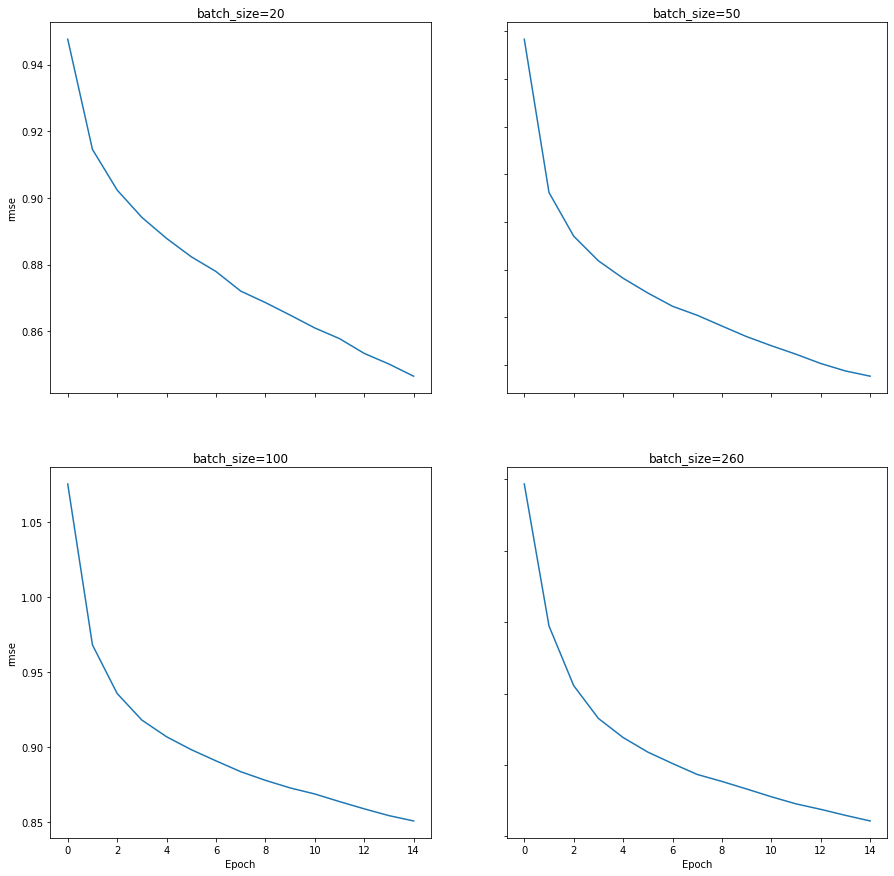

In [116]:
f, axarr = plt.subplots(2, 2,figsize=(15,15))
fig.suptitle('Batch Size Optimization')
axarr[0, 0].plot(h1.history['rmse'])
axarr[0, 0].set_title('batch_size=20')
axarr[0, 1].plot(h2.history['rmse'])
axarr[0, 1].set_title('batch_size=50')
axarr[1, 0].plot(h3.history['rmse'])
axarr[1, 0].set_title('batch_size=100')
axarr[1, 1].plot(h4.history['rmse'])
axarr[1, 1].set_title('batch_size=260')
for ax in axarr.flat:
    ax.set(xlabel='Epoch', ylabel='rmse')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()

10 Epoch

In [6]:

#for 10 epoch
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(hist2.history['loss'], label = 'batch_size=20')
plt.plot(hist3.history['loss'], label = 'batch_size=50')
plt.plot(hist4.history['loss'], label = 'batch_size=100')
plt.plot(hist5.history['loss'], label = 'batch_size=265')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MAE loss')
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [231]:
train_dataset

<MapDataset shapes: (OrderedDict([(user_id, (None,)), (seq_movie_id, (None, None)), (sequence_ratings, (None, None)), (sex, (None,)), (age_group, (None,)), (occupation, (None,)), (target_movie_id, (None,))]), (None,)), types: (OrderedDict([(user_id, tf.string), (seq_movie_id, tf.string), (sequence_ratings, tf.float32), (sex, tf.string), (age_group, tf.string), (occupation, tf.string), (target_movie_id, tf.string)]), tf.float32)>

In [232]:
test_dataset

<MapDataset shapes: (OrderedDict([(user_id, (None,)), (seq_movie_id, (None, None)), (sequence_ratings, (None, None)), (sex, (None,)), (age_group, (None,)), (occupation, (None,)), (target_movie_id, (None,))]), (None,)), types: (OrderedDict([(user_id, tf.string), (seq_movie_id, tf.string), (sequence_ratings, tf.float32), (sex, tf.string), (age_group, tf.string), (occupation, tf.string), (target_movie_id, tf.string)]), tf.float32)>

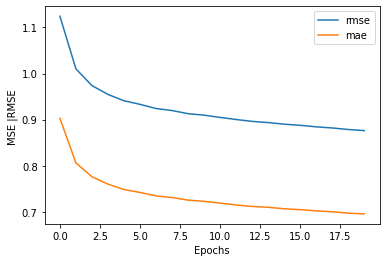

In [309]:
# plot metrics

import matplotlib.pyplot as pyplot
plt.clf()
pyplot.plot(history['rmse'],label='rmse')
pyplot.plot(history['MAE'],label='mae')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE |RMSE ')
pyplot.show()

In [310]:
prediction=model.predict(test_dataset)
prediction

array([[4.06349  ],
       [4.075888 ],
       [4.032781 ],
       ...,
       [3.0642977],
       [2.531025 ],
       [3.2447448]], dtype=float32)

<Figure size 432x288 with 0 Axes>

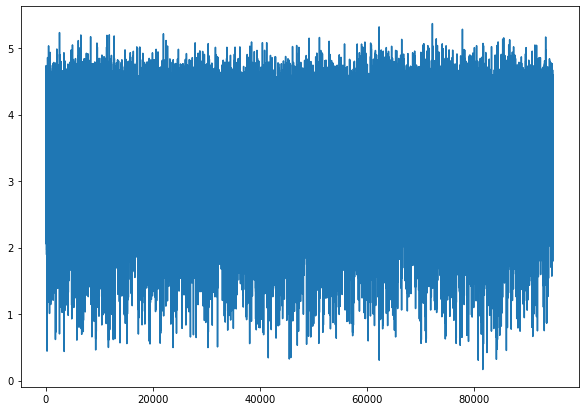

In [186]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(model.predict(test_dataset))
plt.show()

In [42]:
test_data

,user_id,seq_movie_id,sequence_ratings,sex,age_group,occupation
4,u_1,"m_2804,m_260,m_720,m_1193,m_919,m_608,m_2692,m...","5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0",F,g_1,occ_10
5,u_1,"m_720,m_1193,m_919,m_608,m_2692,m_1961,m_2028,...","3.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0",F,g_1,occ_10
8,u_1,"m_2028,m_3105,m_938,m_1035,m_1962,m_1028,m_201...","5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,4.0,3.0,5.0,4.0",F,g_1,occ_10
10,u_1,"m_1962,m_1028,m_2018,m_150,m_1097,m_914,m_1287...","4.0,5.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,4.0,3.0,4.0",F,g_1,occ_10
14,u_1,"m_1246,m_2762,m_661,m_2918,m_531,m_3114,m_2791...","4.0,4.0,3.0,4.0,4.0,4.0,4.0,5.0,3.0,3.0,4.0,4.0",F,g_1,occ_10
...,...,...,...,...,...,...
474448,u_999,"m_371,m_382,m_1027,m_1442,m_2146,m_358,m_2541,...","3.0,3.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0",M,g_25,occ_15
474455,u_999,"m_3156,m_282,m_1888,m_209,m_207,m_79,m_2875,m_...","4.0,4.0,3.0,2.0,4.0,3.0,4.0,3.0,1.0,3.0,3.0,3.0",M,g_25,occ_15
474456,u_999,"m_1888,m_209,m_207,m_79,m_2875,m_2316,m_2165,m...","3.0,2.0,4.0,3.0,4.0,3.0,1.0,3.0,3.0,3.0,2.0,1.0",M,g_25,occ_15
474458,u_999,"m_2875,m_2316,m_2165,m_361,m_2688,m_24,m_2264,...","4.0,3.0,1.0,3.0,3.0,3.0,2.0,1.0,3.0,2.0,3.0,3.0",M,g_25,occ_15


In [44]:
plt.plot(test_data['user_id'],test_data['sequence_ratings'],'.',test_data['user_id'],hd5.predict(test_dataset), '-')

NameError: ignored

In [311]:
for i in test_dataset:
  print(i[0])
  print(i[1])
  # print(i[0]['target_movie_id'])
  # print(prediction[:265])
 
  break
     
i=0
user_movie_rating = dict()
for line in test_dataset:
  # for row in line:
  for user_id, movie_id, act_rating in zip(line[0]['user_id'], line[0]['target_movie_id'], line[1]):
    try:
      user_movie_rating[user_id.numpy().decode()].append((movie_id.numpy().decode(), act_rating.numpy(), prediction[i][0]))
    except KeyError:
      user_movie_rating[user_id.numpy().decode()] = [(movie_id.numpy().decode(), act_rating.numpy(), prediction[i][0])]
    i+=1  
  

OrderedDict([('user_id', <tf.Tensor: shape=(265,), dtype=string, numpy=
array([b'u_1', b'u_1', b'u_1', b'u_1', b'u_1', b'u_1', b'u_10', b'u_10',
       b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10',
       b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10',
       b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10',
       b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10',
       b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_10', b'u_100',
       b'u_100', b'u_100', b'u_100', b'u_100', b'u_100', b'u_1000',
       b'u_1000', b'u_1000', b'u_1000', b'u_1000', b'u_1000', b'u_1000',
       b'u_1000', b'u_1000', b'u_1000', b'u_1001', b'u_1001', b'u_1001',
       b'u_1001', b'u_1001', b'u_1001', b'u_1001', b'u_1001', b'u_1001',
       b'u_1001', b'u_1001', b'u_1001', b'u_1001', b'u_1001', b'u_1001',
       b'u_1001', b'u_1001', b'u_1001', b'u_1001', b'u_1001', b'u_1001',
       b'u_1001', b'u_1001', b'u_1001', b'u_1001', b'u_1001', b'u_1001'

In [238]:
# user_movie_rating.head

AttributeError: ignored

In [316]:
preds = []
for user, values in user_movie_rating.items():
  if len(values) > 5:
    for movie, rating, predicted in values:
      preds.append((user, movie, rating, predicted))


In [335]:
from collections import defaultdict
def GetTopN(predictions, n=10, minimumRating=4.0):
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating in predictions:
        if (estimatedRating >= minimumRating):
            topN[userID].append((movieID, estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[userID] = ratings[:n]

    return topN
a= GetTopN(preds, 5, 2)['u_19']
print(a)

[('m_1080', 4.29289), ('m_2000', 4.1978126), ('m_1073', 4.0988812), ('m_1234', 4.0744405), ('m_1196', 3.9388442)]


In [337]:
print('Top 5 recommendation for  User_1d : 19')
for i in a:
    print(movies[movies['movie_id'] == i[0]]['title'].values[0],"|",movies[movies['movie_id'] == i[0]]['genres'].values[0])
 

Top 5 recommendation for  User_1d : 19
Monty Python's Life of Brian (1979) | Comedy
Lethal Weapon (1987) | Action|Comedy|Crime|Drama
Willy Wonka and the Chocolate Factory (1971) | Adventure|Children's|Comedy|Fantasy
Sting, The (1973) | Comedy|Crime
Star Wars: Episode V - The Empire Strikes Back (1980) | Action|Adventure|Drama|Sci-Fi|War


In [342]:
'''Return precision and recall at k metrics for each user.'''
# First map the predictions to each user.
threshold=2.0
k=25
user_est_true = defaultdict(list)
for uid, _, true_r, est in preds:
    user_est_true[uid].append((est, true_r))
precisions = dict()
recalls = dict()
for uid, user_ratings in user_est_true.items():
    # Sort user ratings by estimated value
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    # Number of relevant items
    n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
    # Number of recommended items in top k
    n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
    # Number of relevant and recommended items in top k
    n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                          for (est, true_r) in user_ratings[:k])
    # Precision@K: Proportion of recommended items that are relevant
    precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    # Recall@K: Proportion of relevant items that are recommended
    recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
#tp = n_rel_and_rec_k
#fn =  n_rel - tp
#fp = n_rec_k - tp
print(precisions)
print(recalls)
precision_list=[]
recalls_list=[]
for key, value in precisions.items():
    # temp = [key,value]
    precision_list.append(value)

for key, value in recalls.items():
    # temp = [key,value]
    recalls_list.append(value)    
print("precisions @ 5 is {:.2f}".format(np.average(precision_list)))
print("Recall @ 5 is {:.2f}".format(np.average(recalls_list)))


{'u_1': 1.0, 'u_10': 1.0, 'u_100': 0.8333333333333334, 'u_1000': 1.0, 'u_1001': 1.0, 'u_1002': 1.0, 'u_1004': 0.96, 'u_1005': 0.8, 'u_1008': 1.0, 'u_101': 1.0, 'u_1010': 0.96, 'u_1012': 0.8333333333333334, 'u_1015': 1.0, 'u_1016': 1.0, 'u_1017': 1.0, 'u_1018': 1.0, 'u_1019': 1.0, 'u_102': 0.7142857142857143, 'u_1020': 1.0, 'u_1021': 1.0, 'u_1022': 0.8571428571428571, 'u_1028': 1.0, 'u_1029': 0.875, 'u_103': 1.0, 'u_1030': 1.0, 'u_1031': 1.0, 'u_1032': 1.0, 'u_1033': 1.0, 'u_1034': 0.92, 'u_1035': 0.9166666666666666, 'u_1036': 1.0, 'u_1037': 1.0, 'u_1038': 0.875, 'u_104': 1.0, 'u_1040': 1.0, 'u_1041': 1.0, 'u_1044': 1.0, 'u_1047': 1.0, 'u_105': 1.0, 'u_1050': 1.0, 'u_1051': 0.88, 'u_1052': 1.0, 'u_1053': 1.0, 'u_1054': 0.9090909090909091, 'u_1055': 0.8333333333333334, 'u_1056': 1.0, 'u_1057': 1.0, 'u_1058': 1.0, 'u_1059': 0.84, 'u_106': 1.0, 'u_1062': 1.0, 'u_1063': 1.0, 'u_1064': 1.0, 'u_1065': 1.0, 'u_1066': 1.0, 'u_1067': 1.0, 'u_1068': 1.0, 'u_1069': 0.92, 'u_107': 1.0, 'u_1071': 1.

Hit rate

In [ ]:
pip install tqdm

In [ ]:
from tqdm import tqdm as tqdm
import torch
# User-item pairs for testing
test_ratings=pd.DataFrame(data=preds, columns=['user_id','movie_id','actual_rating','pred_rating'])
test_user_item_set = set(zip(test_ratings['user_id'].values, test_ratings['movie_id'].values))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('user_id')['movie_id'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(ratings['movie_id'].unique()) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    # predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
    #                                     torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort([x[1] for x in preds])[::-1][0:5].tolist()]
    # top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/41575 [00:00<?, ?it/s]


IndexError: ignored

In [ ]:
# from lightfm import LightFM
# from lightfm.evaluation import precision_at_k
# from lightfm.evaluation import auc_score

# # model = LightFM(learning_rate=0.05, loss='bpr')
# # model.fit(train, epochs=10)

# train_precision = precision_at_k(model, train_dataset, k=10).mean()
# test_precision = precision_at_k(model, test_dataset, k=10).mean()

# train_auc = auc_score(model, train).mean()
# test_auc = auc_score(model, test).mean()

# print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
# print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

# Sequential Model Results on Movielens 1-M Datasets

MAE on 5 epoch

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
labels = ['Transformer', 'RNN', 'LSTM', 'GRU']
values = [0.779, 0.993, 0.94, 0.92]
# Change the bar colors here
plt.bar(labels, values, color=['red', 'blue', 'purple', 'green'])
plt.xlabel("Models for 5 Epochs")
plt.ylabel('MAE')
plt.show()


MAE on 10 epoch